In [123]:
%pylab inline
from scipy import optimize
from IPython.display import display, Math, Latex
import emcee
import matplotlib.gridspec as gridspec
#import corner
from scipy import stats 

Populating the interactive namespace from numpy and matplotlib


In [124]:
#mass units
M = (10.0**10)/0.7
#vol of illustris run
vol = (75.0/(0.7))**3
print(75./0.7)

# Gives the x,y of the histogram for logmasses from the given array of mass
def histog( mf, nbins ):
    hist, bin_edges = np.histogram(mf, bins = nbins)
    # Obtains the center point for each bin
    xcenter = (bin_edges[:-1] + bin_edges[1:])/2
    return np.array(xcenter), np.array(hist/vol)

# Truncates float to n decimal parts
def truncate(d,n):
    before_dec, after_dec = str(d).split('.')
    d = float('.'.join((before_dec, after_dec[0:n-1])))
    return d

# Schechter function
def Schechter(m,phi_s,alpha,m_s):
    MHI = 10.**m
    M_s = 10.**m_s
    return np.log(10.)*phi_s*((MHI/M_s)**(alpha+1))*numpy.exp(-MHI/M_s)

# loads the file with halo masses and makes the quartiles
# file formated env,mass
# j defines if we treat gass or dm j = 0,1
# j = 0 -> gas
# j = 1 -> dm
# j = 2 -> stars and dust
# j = 3 -> black holes
# j = 4 -> central black hole
# minMass minimum mass allowed to have into account a halo
def loadHaloes(name, massname, neigh, j, minMass):
    table = np.loadtxt(name, skiprows = 0, delimiter = ',').T
    mtable = np.loadtxt(massname, skiprows = 0, delimiter  = ',').T
    #table[0] = neigh/(np.pi*table[0]+1e-9)
    print("number of haloes before: " + str(len(table.T)))
    
    # Only take the haloes with not null mass
    lsigma = table[0][where((M*mtable[j])> minMass)]
    mass = M*mtable[j][where(M*mtable[j]> minMass)]
    
    print("number of haloes after: " + str(len(mass)))

    # Calculates the first quartile of logsigma
    global q1
    global q2
    global q3
    global q4
    global q5
    q5 = M*mtable[j][where(M*mtable[j]> minMass)]

    
    q = np.percentile(lsigma,25)
    # Keeps first quartile
    q1 = mass[where(lsigma <= q)]
    # Removes fist quartile from lsigma
    mass = mass[where(lsigma > q)]
    lsigma = lsigma[where(lsigma > q)]
    # Second quartile
    q = np.percentile(lsigma,33.333333)
    q2 = mass[where(lsigma <= q)]
    mass = mass[where(lsigma > q)]
    lsigma = lsigma[where(lsigma > q)]
    # Third and Fourth quartile
    q = np.percentile(lsigma,50)
    q3 = mass[where(lsigma <= q)]
    q4 = mass[where(lsigma >= q)]
    
    # verify the length of each quartile
    print(len(q1),len(q2),len(q3),len(q4), sum([len(q1),len(q2),len(q3),len(q4)]))

# Loads the file with environment classification T-Web
# file formated env,massgas,masdm
# j defines if we treat gass or dm j = 0,1
# minMass minimum mass allowed to have into account a halo
def loadTweb(name, massname, neigh, j, minMass):
    table = np.loadtxt(name, skiprows = 0, delimiter = ',').T
    mtable = np.loadtxt(massname, skiprows = 0, delimiter  = ',').T
    #table[0] = neigh/(np.pi*table[0]+1e-9)
    print("number of haloes before: " + str(len(table.T)))
    
    # Only take the haloes with not null mass
    lsigma = table[0][where((M*mtable[j]) > minMass)]
    mass = M*mtable[j][where(M*mtable[j] > minMass)]
    
    print("number of haloes after: " + str(len(mass)))

    # Calculates the first quartile of logsigma
    global q1 
    global q2 
    global q3 
    global q4 
    global q5 
    q1 = mass[np.where(lsigma == 3)]
    q2 = mass[np.where(lsigma == 2)]
    q3 = mass[np.where(lsigma == 1)]
    q4 = mass[np.where(lsigma == 0)]
    q5 = mass
    # verify the length of each quartile
    print(len(q1),len(q2),len(q3),len(q4), sum([len(q1),len(q2),len(q3),len(q4)]))
    
def SchtrGraph2(bins,filename,title, boolean):
    # Graphics of the mass function for each quartile
    fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(10,7) )
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
    #gs = gridspec.GridSpec(2,1)
    #ax0 = plt.subplot(gs[0, 0])
    
    # Plots Total mass function
    '''
    fig, axes = plt.subplots( nrows=2, ncols=1, figsize=(15,20) )
    gs = gridspec.GridSpec(2,1)
    ax0 = plt.subplot(gs[0, 0])
    ax = plt.subplot(gs[1,0])
    tmp = histog(log10(q5),bins+5)
    tmp = [tmp[0][where(tmp[1]!=0)],tmp[1][where(tmp[1]!=0)]]
    ax0.errorbar( tmp[0], log10(tmp[1]),  1./(sqrt(tmp[1]*vol)), fmt='o', ecolor = 'b',
                        c = 'g', markersize=7,elinewidth=1.5)
    '''
    
    # Callable lists
    qs = [q1,q2,q3,q4]
    indx = ['1st quartile','2nd quartile','3rd quartile','4th quartile']
    cs = ['b','g','r','y']
    fmts = ['o','>','<','s']
    alph = []
    dalph = []
    ms = []
    dms = []
    minx = 40
    maxx = -1
    miny = 100
    maxy = -100
    # Chooses normalization factor as first phi_s
    tmp = histog(log10(q1),15)
    #rint(tmp)
    tmp = [tmp[0][where(tmp[1]!=0)],tmp[1][where(tmp[1]!=0)]]
    phi = 1
    if ( boolean ):
        fiiit,sampler = fitMCMC(tmp)
        #print(fiiit)
        ft = fiiit.T[0]
        errors = fiiit.T[1:]
        phi = ft[0]
    ind = 0
    for q,i,co,fm in zip(qs,indx,cs,fmts):
        # Histo for first quartile
        tmp = histog(log10(q),bins)
        tmp = [tmp[0][where(tmp[1]!=0)],tmp[1][where(tmp[1]!=0)]]
        #print tmp
        if ( boolean ):
            logm = linspace(min(tmp[0])-0.3,max(tmp[0])+0.1, 200)
            fiiit,sampler = fitMCMC(tmp)
            #print(fiiit)
            ft = fiiit.T[0]
            errors = fiiit.T[1:].T
            print("......................................................")
            print(ft[0],errors[0])
            print(ft[1],errors[1])
            print(ft[2],errors[2])
            ax.errorbar( tmp[0], log10(tmp[1]*(phi/ft[0]))-ind,  1./(sqrt(tmp[1]*vol)), fmt=fm, ecolor = co,
                        c = co, markersize=7,elinewidth=1.5)
        else: 
            ax.errorbar( tmp[0], log10(tmp[1]),  1./(sqrt(tmp[1]*vol))-ind, fmt=fm, ecolor = co,
                        c = co, markersize=7,elinewidth=1.5)
        # Decimals to show
        if ( boolean ):
            m = 5
            ax.plot(logm, log10(Schechter(logm,ft[0],ft[1],ft[2])*(phi/ft[0])) -ind,co, 
                 label = r"$\alpha$ = " + str(truncate(ft[1],m))+"\n"
                 + r"$m_\ast$ = " + str(truncate(ft[2],m))+"\n"  )
            alph.append(ft[1])
            dalph.append(errors[1])
            ms.append(ft[2])
            dms.append(errors[2])
            #ax.bar( tmp[0] , log10(tmp[1]), width = tmp[0][1]-tmp[0][2], alpha = 0.4, align = 'center' )
            ax.legend(prop={'size':13})
        #savetxt(name + "q2.csv",(array([tmp[0], tmp[1], sqrt(vol*tmp[1])/(vol*tmp[1])]).T), delimiter = ',')
        #ax.set_title(i, fontsize = 18)
        ax.set_ylabel('$Log_{10}(n)$', fontsize = 20)
        ax.set_xlabel('$Log_{10}(M/M_{\odot})$', fontsize = 20)
        minx = min([minx,min(tmp[0])])
        maxx = max([maxx,max(tmp[0])])
        if ( boolean ):
            miny = min([miny,min(log10(tmp[1]*(phi/ft[0])))-ind])
            maxy = max([maxy,max(log10(tmp[1]*(phi/ft[0])))-ind])
        else:
            miny = min([miny,min(log10(tmp[1]))-ind])
            maxy = max([maxy,max(log10(tmp[1]))-ind])
        ################################################################
        ind += 0.5
    ax.set_title(title,fontsize = 20)
    tmp = histog(log10(q5),bins)
    ax.set_xlim(minx-0.3,maxx+0.3)
    if ( boolean ):
        ax.set_xlim(minx-0.3,maxx+1.5)
    ax.set_ylim(miny-0.3,maxy+0.3)
    #ax.set_ylim(-6.,0.)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    savefig(filename)
    return array(alph),array(dalph).T,array(ms),array(dms).T

    
def graph(x,dx,d,name,title,filename):
    fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(10,7) )
    q = [1,2,3,4]
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
    ax.errorbar( q, x, yerr = dx, fmt='o', ecolor = 'r', c = 'b', markersize=7,elinewidth=1.5)
    ax.set_xlim(0.5,4.5)
    ax.set_ylim(min(x)-d,max(x)+d)
    ax.set_ylabel(name, fontsize = 30)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_xlabel(r'$Environment$', fontsize = 30)
    ax.set_title(title, fontsize = 30)
    savefig(filename)


107.14285714285715


In [125]:
# Defines functions for emcee
def lnprior(p):
    # The parameters are stored as a vector of values, so unpack them
    norm,alpha,m = p
    # We're using only uniform priors, and only eps has a lower bound
    if norm > 0 and   8 < m < 20 and -3 < alpha < 1:
        return 0
    return -np.inf

# Defines the likelihood
def lnlike(p, x, y, yerr):
    model = SchechterMC(x,p)
    # the likelihood is sum of the lot of normal distributions
    denom = power(yerr,2.)
    lp = -0.5*sum(power((y - model),2.)/denom + log(denom)) 
    return lp

# The probability
def lnprob(p, x, y, yerr):
    lp = lnprior(p)
    if not isfinite(lp):
        return -np.inf
    return lp + lnlike(p, x, y, yerr)

# MCMC fit
p0 = [0.003, -1., 10.]
def fitSci(tmp,yerr,p):
    return optimize.curve_fit(Schechter,tmp[0] ,tmp[1],p0=[0,-2.0,12], sigma = np.sqrt(tmp[1]/vol),
    #bounds = (np.array([0,-np.inf,8.]),np.array([np.inf,np.inf,20.])),method = 'trf',
    maxfev = 100000)


# Schechter function
def SchechterMC(m,params):
    MHI = 10.**m
    M_s = 10.**params[2]
    return np.log(10.)*params[0]*((MHI/M_s)**(params[1]+1))*numpy.exp(-MHI/M_s)

# Gets the error taking into account the confidence interval
# Arr -> the array
# center -> central value to calculate the interval
# perc -> percent of data within the interval
def getErr(arr, center, perc):
    #conf_int  = stats.norm.interval(perc, loc = center, scale = 1 )
    conf_int  = stats.norm.interval(perc, loc = center, scale = np.std(arr))
    return conf_int

# Uses MCMC emcee to improve the SchechterMC fit and error estimation
# return the best fit values and their respective errors within confidence interval given by perc = (0.68,0.95)
# temp -> data to fit
# Nsteps -> steps for MCMC
# Nwalkers -> number of MCMC walkers
# suggestion: fitMCMC(temp,0.68,1000,50)
def fitMCMC(tmp):
    Nsteps = 1000
    Nwalker = 50
    tmp = [tmp[0][where(tmp[1]!=0)],tmp[1][where(tmp[1]!=0)]]
    # The error in y assuming poisson dist
    yerr = sqrt(tmp[1]/vol)
    # Uses scipy fit as initial guess
    p00 = [0.003,-1.,10.]
    ft,errors = fitSci(tmp,yerr,p00)
    #print ft
    # Creates walkers around initial guess
    Ndim = 3
    walkers = [ft+[1.e-7*random.randn(),1.e-4*random.randn(),1.e-3*random.randn()] for i in range(Nwalker)]
    # Initialises sampler
    sampler = emcee.EnsembleSampler(Nwalker,Ndim,lnprob,args=(tmp[0],tmp[1],yerr))
    pos,prob,state = sampler.run_mcmc(walkers, 500)
    sampler.reset()
    #res=plot(sampler.chain[:,:,1].T, '-', color='k', alpha=0.3)
    #axhline(ft[1], color='blue')
    # Runs the walks
    pos,prob,state = sampler.run_mcmc(pos, Nsteps)
    # fit and Errors in format (fit,upper,lower)
    samples = sampler.chain[:, 50:, :].reshape((-1, Ndim))
    #corner.corner(samples, labels=['normV','alpha','m*'], 
     #           truths=[ft[0], ft[1], ft[2]])
    #print shape(samples)
    fit = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))
    return array(list(fit)),samples

# GAS NEAREST NEIGHBOR

number of haloes before: 191443
number of haloes after: 144832
36208 36208 36208 36208 144832
......................................................
0.00195271081448 [  3.78011176e-05   3.61143026e-05]
-1.04818073976 [ 0.00593009  0.00582196]
10.6287511148 [ 0.00788111  0.00801782]
......................................................
0.00356347125584 [  6.39964324e-05   6.54235147e-05]
-0.910093596648 [ 0.00776088  0.00775158]
10.2573724026 [ 0.00761843  0.00766894]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:171: RuntimeWarning: divide by zero encountered in log10


......................................................
0.00224391667334 [  3.51165366e-05   3.58745618e-05]
-0.818743731213 [ 0.00790916  0.00815143]
10.1143641044 [ 0.00652495  0.00662717]
......................................................
0.00232902369597 [  3.84978294e-05   3.89156091e-05]
-0.80164937031 [ 0.00897862  0.00914247]
10.0046553677 [ 0.00693744  0.00734984]


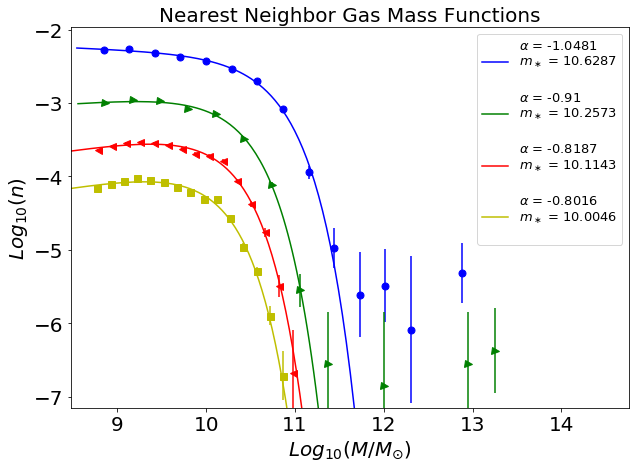

In [126]:
loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,0,10**(8.7))
#loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,0,0)
#histo(15)
a = SchtrGraph2(15,"quartilesGas","Nearest Neighbor Gas Mass Functions",True)

In [127]:
alph,dalph,ms,dms = a
print(dms.T)

[[ 0.00788111  0.00801782]
 [ 0.00761843  0.00766894]
 [ 0.00652495  0.00662717]
 [ 0.00693744  0.00734984]]


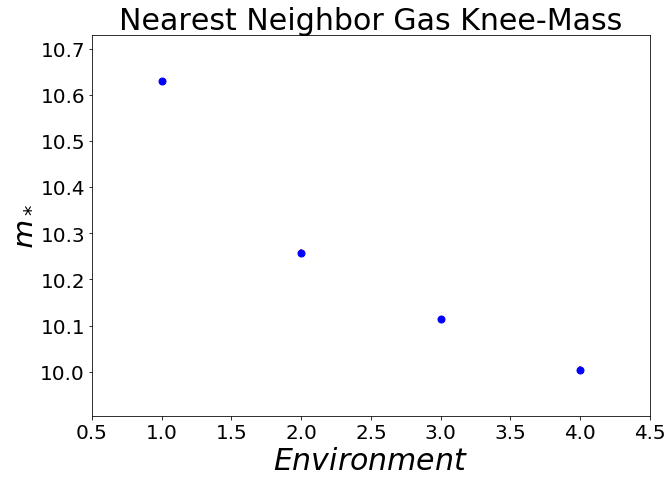

In [128]:
graph(ms,dms,0.1,r"$m_*$","Nearest Neighbor Gas Knee-Mass","Quartiles_knee_mass_gas")

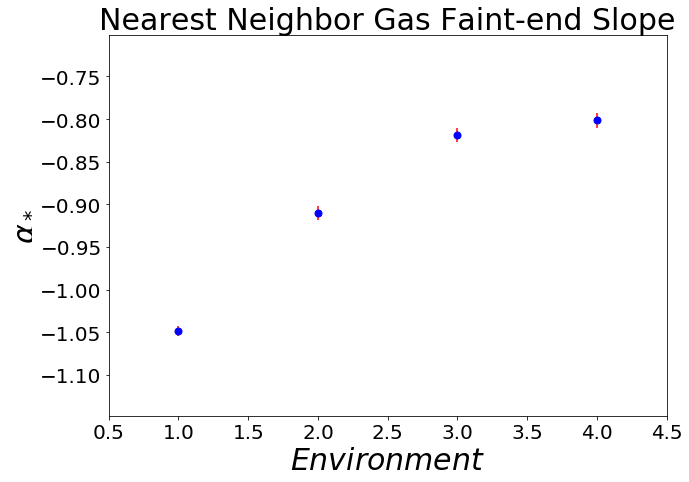

In [129]:
graph(alph,dalph,0.1,r"$\alpha_*$","Nearest Neighbor Gas Faint-end Slope","quartiles_slope_gas")

# GAS TWEB

number of haloes before: 191443
number of haloes after: 144832
16982 72021 48900 6929 144832
......................................................
0.00122860955765 [  4.20092087e-05   4.07826592e-05]
-1.02025946588 [ 0.01141688  0.01158504]
10.4055530231 [ 0.01536205  0.0150051 ]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:171: RuntimeWarning: divide by zero encountered in log10


......................................................
0.00320074737196 [  4.59596719e-05   4.65607317e-05]
-0.986171160936 [ 0.00517864  0.00509806]
10.3910636591 [ 0.00641244  0.00636736]
......................................................
0.00283030506721 [  4.15951560e-05   4.28656635e-05]
-0.860310095307 [ 0.00715851  0.00695529]
10.1568971686 [ 0.00671315  0.00648312]
......................................................
0.000465727705574 [  1.58574096e-05   1.62651430e-05]
-0.730667164134 [ 0.02170635  0.02221613]
9.88414033011 [ 0.01434049  0.01492882]


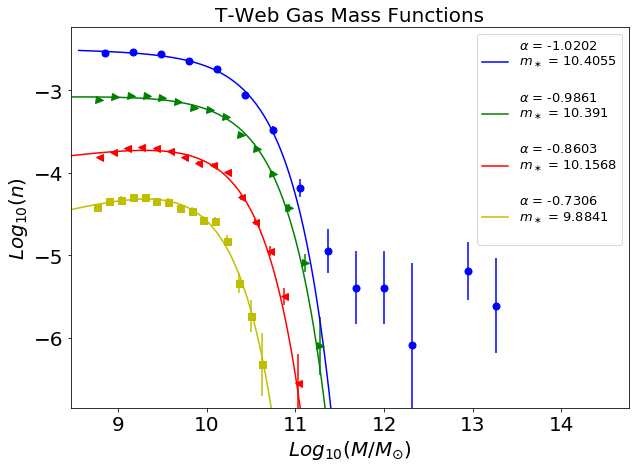

In [162]:
loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,0,10**(8.7))
#loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,0,0)

a = SchtrGraph2(15,"T-Web_Gas","T-Web Gas Mass Functions",True)

In [163]:
alph,dalph,ms,dms = a
print(dms.T)

[[ 0.01536205  0.0150051 ]
 [ 0.00641244  0.00636736]
 [ 0.00671315  0.00648312]
 [ 0.01434049  0.01492882]]


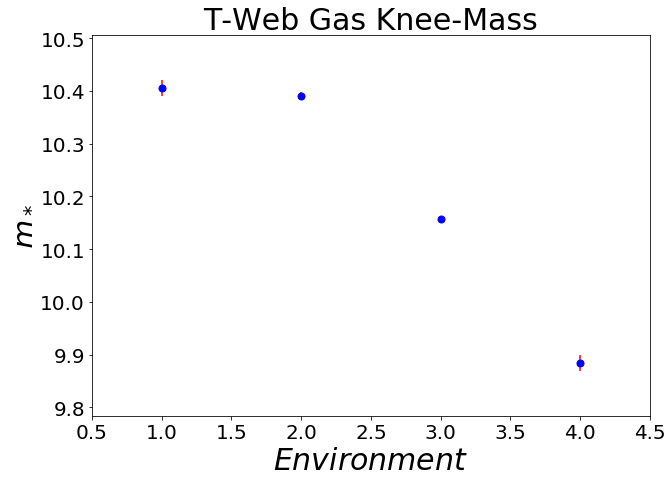

In [164]:
graph(ms,dms,0.1,r"$m_*$","T-Web Gas Knee-Mass","Tweb_knee_mass_Gas")

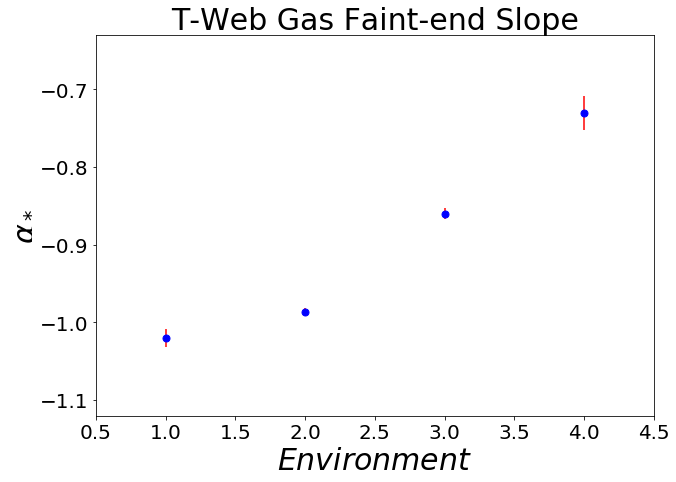

In [165]:
graph(alph,dalph,0.1,r"$\alpha_*$","T-Web Gas Faint-end Slope","TWeb_slope_gas")

# DM NEAREST NEIGHBOR

number of haloes before: 191443
number of haloes after: 115994
28999 28998 28999 28999 115995
......................................................
4.5371158048e-05 [  4.47253708e-06   4.14980231e-06]
-1.58417869582 [ 0.0054447   0.00522423]
13.3204992299 [ 0.0531762   0.05094243]
......................................................
0.00020490133234 [  2.08437290e-05   1.92925193e-05]
-1.71480674645 [ 0.01085655  0.01009455]
12.0055539995 [ 0.03711913  0.03554612]
......................................................
0.000316865925615 [  2.47852055e-05   2.23879909e-05]
-1.68357533411 [ 0.0128779   0.01231072]
11.5334646108 [ 0.02419501  0.02459937]
......................................................
0.000280189194654 [  2.55679124e-05   2.36787021e-05]
-1.80720707256 [ 0.01549113  0.01510024]
11.3597546978 [ 0.02493072  0.02547791]


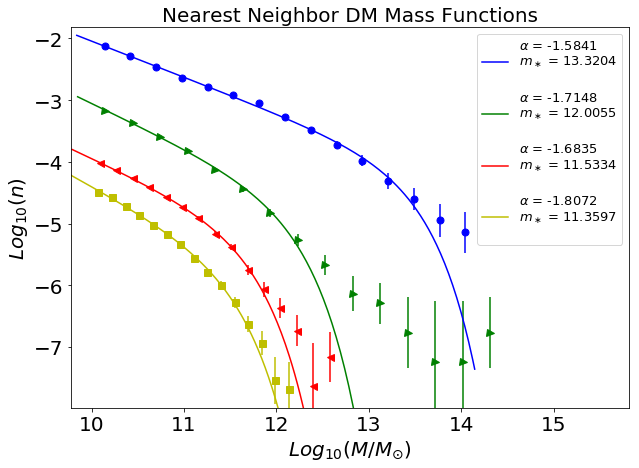

In [134]:
loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,1,10**(10))
#loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,1,0)

#histo(15)
a = SchtrGraph2(15,"quartilesDM","Nearest Neighbor DM Mass Functions",True)

In [135]:
alph,dalph,ms,dms = a
print(dms.T)

[[ 0.0531762   0.05094243]
 [ 0.03711913  0.03554612]
 [ 0.02419501  0.02459937]
 [ 0.02493072  0.02547791]]


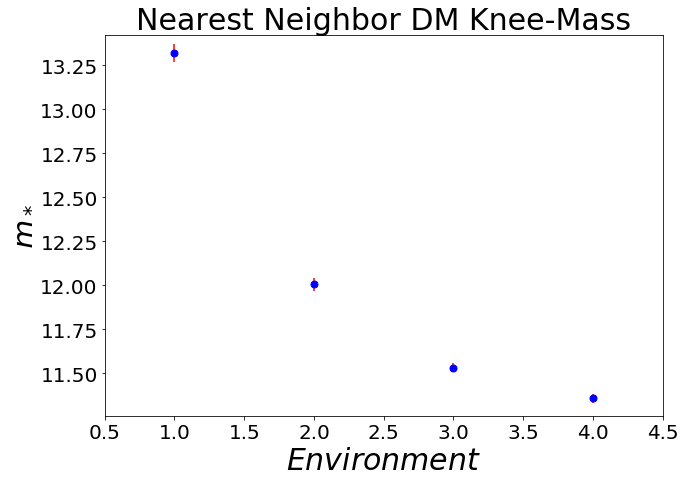

In [136]:
graph(ms,dms,0.1,r"$m_*$","Nearest Neighbor DM Knee-Mass","Quartiles_knee_mass_DM")

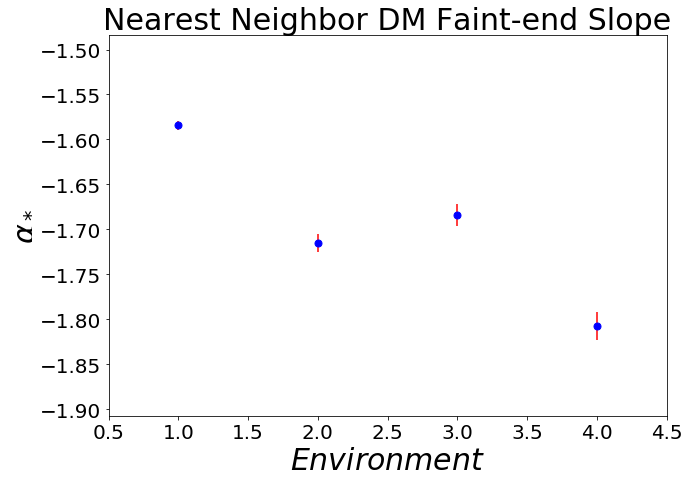

In [137]:
graph(alph,dalph,0.1,r"$\alpha_*$","Nearest Neighbor DM Faint-end Slope","quartiles_slope_DM")

# DM TWEB ( Schechter functions are well adjusted to MF )

number of haloes before: 191443
number of haloes after: 115994
15867 56579 37920 5628 115994


/usr/local/lib/python3.5/dist-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/usr/local/lib/python3.5/dist-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


......................................................
4.42911137484e-09 [  3.03898462e-09   2.55940807e-09]
-1.72046745315 [ 0.00487246  0.00581461]
18.043405602 [ 0.18776231  0.33215066]
......................................................
7.66676297602e-05 [  5.51873329e-06   4.80245767e-06]
-1.75318126079 [ 0.00458135  0.00432557]
12.7091314417 [ 0.02814943  0.02989438]
......................................................
0.000206789439898 [  1.40092928e-05   1.36255311e-05]
-1.76010508492 [ 0.00895295  0.00943909]
11.7098888788 [ 0.02216533  0.02214737]
......................................................
0.000108206934158 [  2.01293119e-05   1.72396682e-05]
-1.67945802471 [ 0.04717551  0.04462914]
11.0100445916 [ 0.0472152   0.04697594]


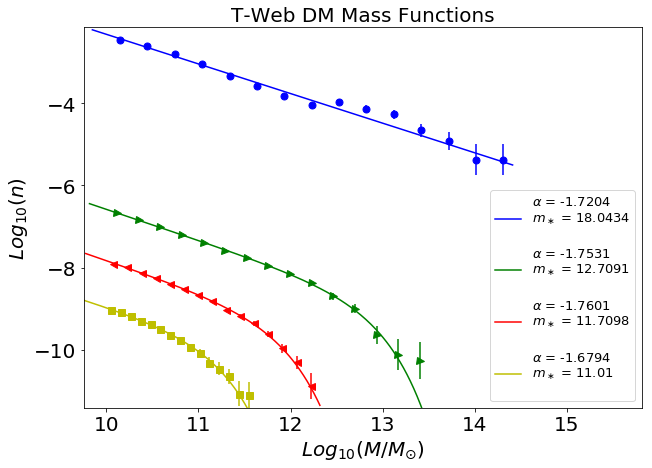

In [166]:
loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,1,10**(10))
#loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,1,0)

a = SchtrGraph2(15,"T-Web_DM","T-Web DM Mass Functions",True)

In [167]:
alph,dalph,ms,dms = a
print(dms.T)

[[ 0.18776231  0.33215066]
 [ 0.02814943  0.02989438]
 [ 0.02216533  0.02214737]
 [ 0.0472152   0.04697594]]


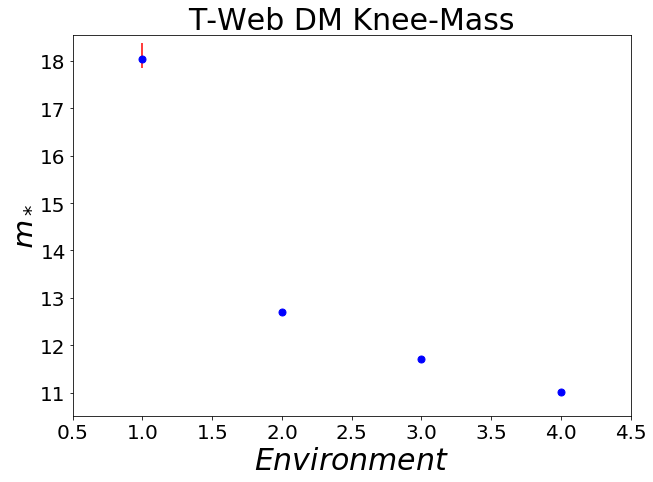

In [168]:
graph(ms,dms,0.5,r"$m_*$","T-Web DM Knee-Mass","Tweb_knee_mass_DM")

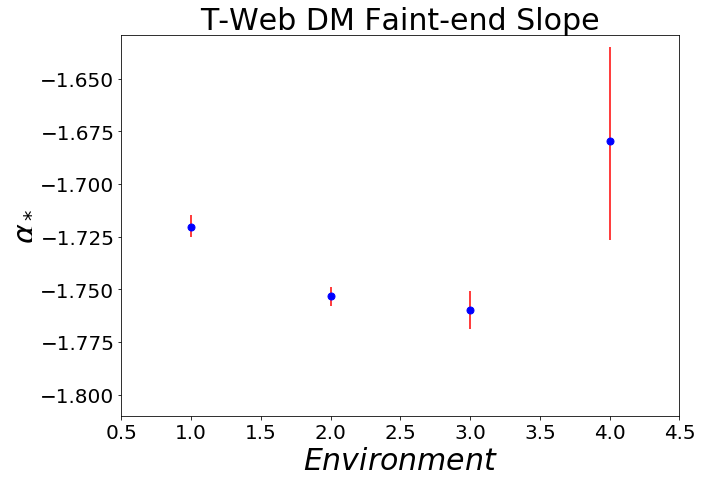

In [169]:
graph(alph,dalph,0.05,r"$\alpha_*$","T-Web DM Faint-end Slope","TWeb_slope_gas")

# NEAREST NEIGHBOR STELLAR MF

number of haloes before: 191443
number of haloes after: 99109
24778 24777 24777 24777 99109
......................................................
0.000350877014086 [  1.00449497e-05   1.01029303e-05]
-1.17198199646 [ 0.0033932   0.00357008]
11.219199311 [ 0.02169031  0.02151733]
......................................................
0.000365184416767 [  1.44133898e-05   1.35012652e-05]
-1.23171626909 [ 0.00476253  0.00457739]
10.6753881402 [ 0.02630809  0.02705467]
......................................................
0.000404506628615 [  1.47817044e-05   1.44544018e-05]
-1.23288948204 [ 0.00573647  0.00566862]
10.2218919317 [ 0.02110983  0.02070893]
......................................................
0.000475729998769 [  1.82610144e-05   1.80097224e-05]
-1.24292790722 [ 0.00671618  0.00676864]
9.90195999708 [ 0.01951265  0.02004399]


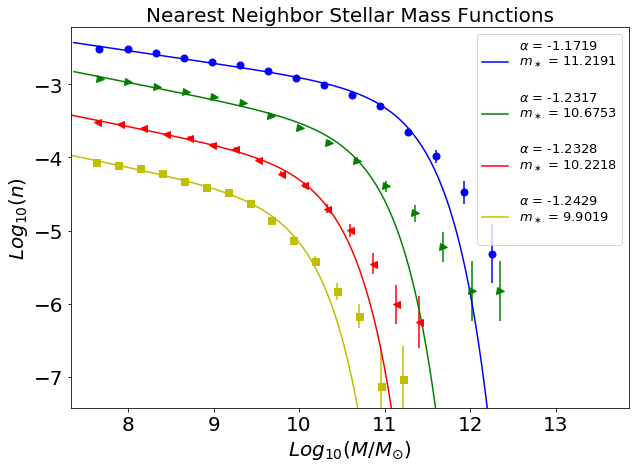

In [142]:
#loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,2,0)
loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,2,10**(7.5))
#histo(15)
a = SchtrGraph2(15,"quartilesSellar","Nearest Neighbor Stellar Mass Functions",True)

In [143]:
alph,dalph,ms,dms = a
print(dms.T)

[[ 0.02169031  0.02151733]
 [ 0.02630809  0.02705467]
 [ 0.02110983  0.02070893]
 [ 0.01951265  0.02004399]]


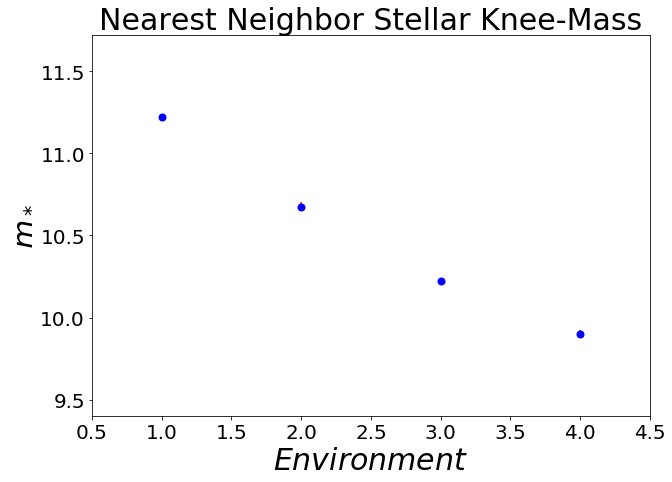

In [144]:
graph(ms,dms,0.5,r"$m_*$","Nearest Neighbor Stellar Knee-Mass","NN_knee_mass_Stellar")

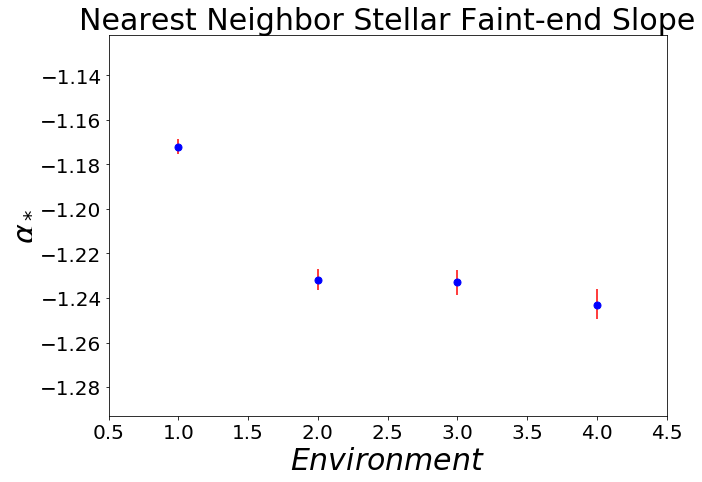

In [145]:
graph(alph,dalph,0.05,r"$\alpha_*$","Nearest Neighbor Stellar Faint-end Slope","NN_slope_Stellar")

# TWEB STELLAR MF

number of haloes before: 191443
number of haloes after: 99109
17942 51362 26647 3158 99109
......................................................
0.000225650551218 [  1.40154430e-05   1.28248086e-05]
-1.19473621287 [ 0.00573357  0.00544234]
11.1947459718 [ 0.05351759  0.05405351]
......................................................
0.000490577892121 [  1.23394902e-05   1.25020106e-05]
-1.26638884765 [ 0.00284782  0.00290177]
10.8738234806 [ 0.0173585  0.0171598]
......................................................
0.000395904034811 [  1.41076587e-05   1.39530924e-05]
-1.24159394983 [ 0.00551144  0.0055333 ]
10.1492561314 [ 0.02020704  0.02019199]
......................................................
6.65793986184e-05 [  6.36696359e-06   6.05777829e-06]
-1.2047840939 [ 0.02217869  0.02184043]
9.52915925925 [ 0.04153564  0.04079129]


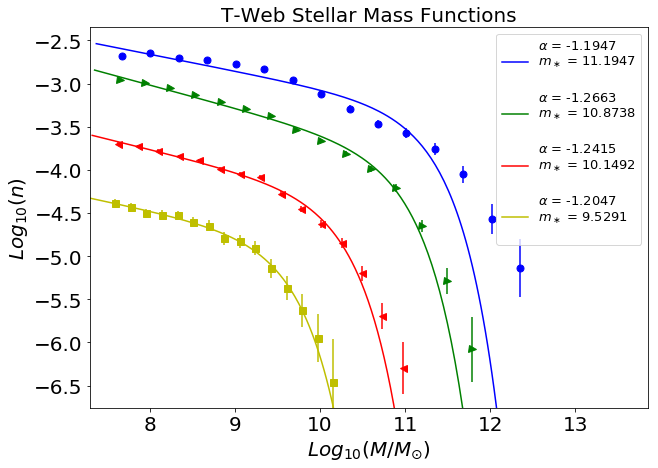

In [146]:
#loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,2,10**(0))
loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,2,10**(7.5))

a = SchtrGraph2(15,"T-Web_Stellar","T-Web Stellar Mass Functions",True)

[[ 0.05351759  0.05405351]
 [ 0.0173585   0.0171598 ]
 [ 0.02020704  0.02019199]
 [ 0.04153564  0.04079129]]


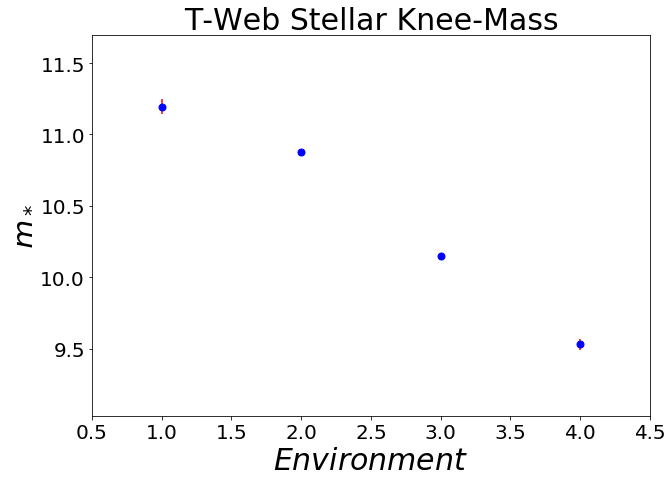

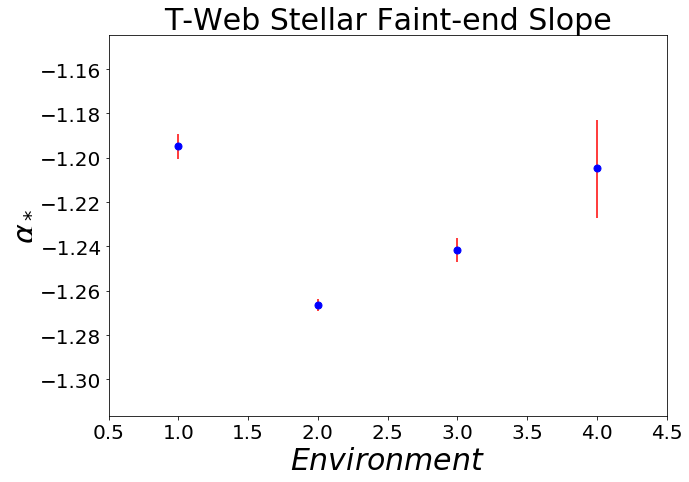

In [147]:
alph,dalph,ms,dms = a
print(dms.T)
graph(ms,dms,0.5,r"$m_*$","T-Web Stellar Knee-Mass","Tweb_knee_mass_Stellar")
graph(alph,dalph,0.05,r"$\alpha_*$","T-Web Stellar Faint-end Slope","Tweb_slope_Stellar")

# NEAREST NEIGHBOR BH MF

number of haloes before: 191443
number of haloes after: 5106
1277 1276 1277 1277 5107
......................................................
6.45448587602e-06 [  2.17463538e-06   1.63095148e-06]
-1.46394464409 [ 0.02864804  0.02658875]
9.46035433407 [ 0.15682267  0.16431609]
......................................................
6.05903844709e-06 [  1.41688695e-06   1.21253569e-06]
-1.40804062089 [ 0.02343417  0.02310633]
9.78635701281 [ 0.12486612  0.11590659]
......................................................
3.43392246498e-06 [  1.48774317e-06   1.21336843e-06]
-1.54293087842 [ 0.03028876  0.02862102]
9.68160502081 [ 0.23788569  0.17933777]


/usr/local/lib/python3.5/dist-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/usr/local/lib/python3.5/dist-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


......................................................
2.3463746321e-07 [  3.08077382e-07   1.87428377e-07]
-1.88333397844 [ 0.02568304  0.02508558]
10.1473791674 [ 0.71896311  0.37780738]


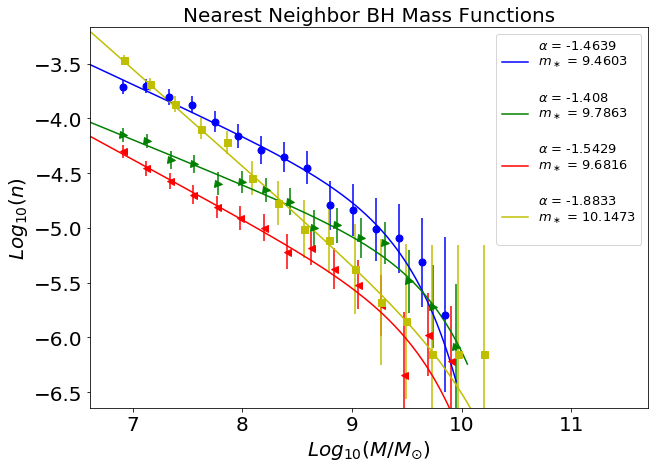

In [170]:
loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,3,10**6.8)
#6.4
#histo(15)
a = SchtrGraph2(15,"quartilesBH","Nearest Neighbor BH Mass Functions",True)

[[ 0.15682267  0.16431609]
 [ 0.12486612  0.11590659]
 [ 0.23788569  0.17933777]
 [ 0.71896311  0.37780738]]


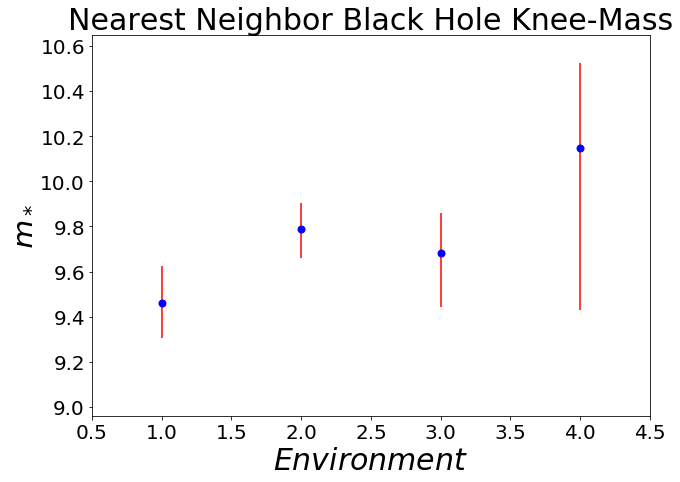

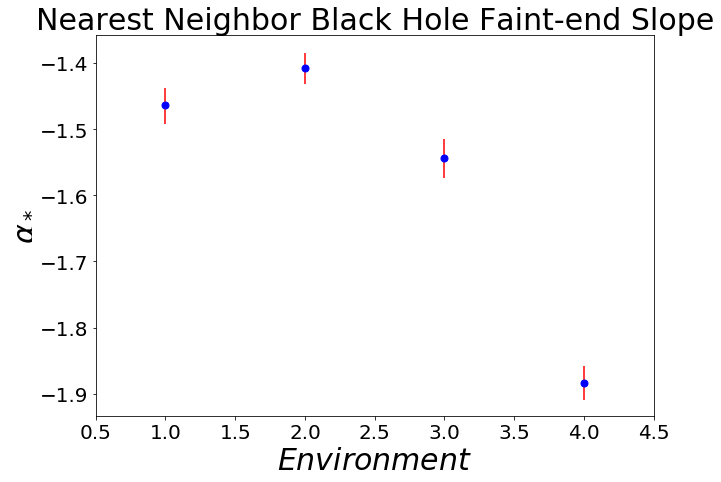

In [171]:
alph,dalph,ms,dms = a
print(dms.T)
graph(ms,dms,0.5,r"$m_*$","Nearest Neighbor Black Hole Knee-Mass","NN_knee_mass_BH")
graph(alph,dalph,0.05,r"$\alpha_*$","Nearest Neighbor Black Hole Faint-end Slope","NN_slope_BH")

# TWEB BH MF

number of haloes before: 191443
number of haloes after: 5106
1828 2838 435 5 5106
......................................................
1.60421014845e-05 [  2.01098784e-06   1.87202461e-06]
-1.30689914625 [ 0.01746467  0.01778164]
9.73201316821 [ 0.05758076  0.06187351]
......................................................
1.70994226843e-05 [  3.32899284e-06   2.89509529e-06]
-1.57183843612 [ 0.02398599  0.02403378]
8.9193573204 [ 0.07484124  0.07293725]


/usr/local/lib/python3.5/dist-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/usr/local/lib/python3.5/dist-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


......................................................
4.87590463486e-06 [  8.82589689e-08   8.85683573e-08]
-1.93488653738 [  9.12645449e-05   1.06485563e-04]
7.7855744535 [ 0.00151924  0.00148654]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:23: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in power


......................................................
-1.72524150761e-08 [  1.36457847e-07   9.19750051e-08]
-1.00881087209 [  1.04263496e-04   6.26759532e-05]
308.215614647 [ 0.00110852  0.00097674]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:163: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:187: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:188: RuntimeWarning: invalid value encountered in log10


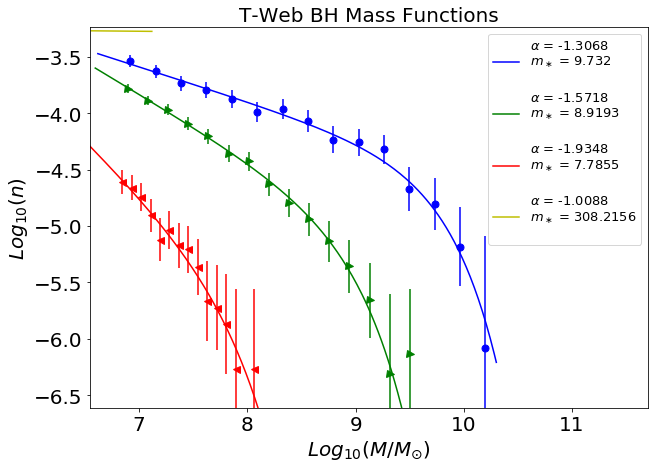

In [150]:
loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,3,10**6.8)
a = SchtrGraph2(15,"T-Web_BH","T-Web BH Mass Functions",True)

[[ 0.05758076  0.06187351]
 [ 0.07484124  0.07293725]
 [ 0.00151924  0.00148654]
 [ 0.00110852  0.00097674]]


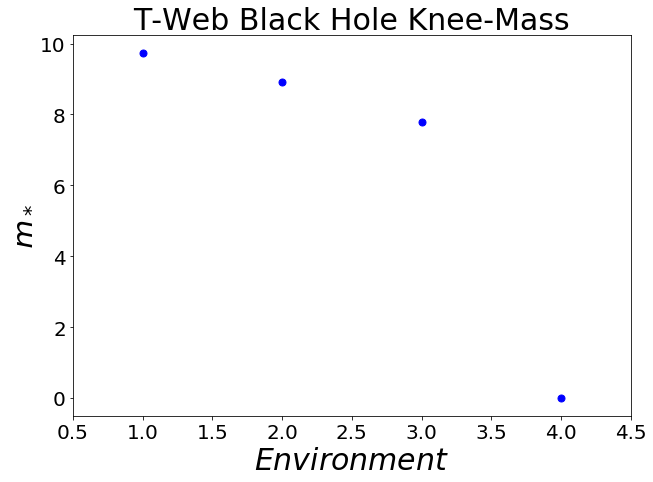

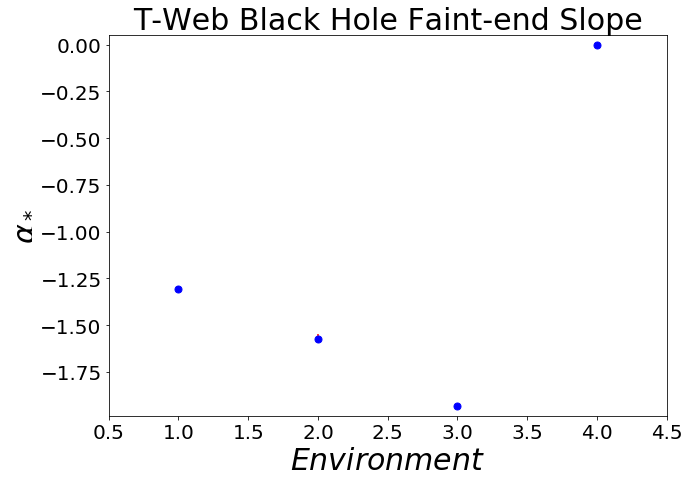

In [158]:
alph,dalph,ms,dms = a
print(dms.T)
alph[-1] = 0
ms[-1] = 0
graph(ms,dms,0.5,r"$m_*$","T-Web Black Hole Knee-Mass","TWeb_knee_mass_BH")
graph(alph,dalph,0.05,r"$\alpha_*$","T-Web Black Hole Faint-end Slope","Tweb_slope_BH")